In [1]:
using Oceananigans
using Oceananigans.Units
using Printf

architecture = CPU()
Nx = 64
Ny = 64
Nz = 64

Lx = 128
Ly = 128
Lz = 64

grid = RectilinearGrid(architecture;
                       size = (Nx, Ny, Nz),
                       x = (0, Lx),
                       y = (0, Ly),
                       z = (-Lz, 0),
                       topology = (Periodic, Periodic, Bounded))

64×64×64 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 3×3×3 halo
├── Periodic x ∈ [0.0, 128.0) regularly spaced with Δx=2.0
├── Periodic y ∈ [0.0, 128.0) regularly spaced with Δy=2.0
└── Bounded  z ∈ [-64.0, 0.0] regularly spaced with Δz=1.0

In [2]:
τˣ = -1e-4
Jᵇ = 1e-7

x_wind_stress = FluxBoundaryCondition(τˣ)
cooling = FluxBoundaryCondition(Jᵇ)
u_bcs = FieldBoundaryConditions(top=x_wind_stress)
b_bcs = FieldBoundaryConditions(top=cooling)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── top: FluxBoundaryCondition: 1.0e-7
└── immersed: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)

In [3]:
f = 1e-4
coriolis = FPlane(; f)

FPlane{Float64}(f=0.0001)

In [4]:
La = 0.3 # √u★ / uˢ

u★ = sqrt(abs(τˣ))
Uˢ = u★ / La^2

λ = 60 # m
k = 2π / λ

uˢ(z) = Uˢ * exp(2k * z)
∂z_uˢ(z, t) = 2k * Uˢ * exp(2k * z)

stokes_drift = UniformStokesDrift(; ∂z_uˢ)

UniformStokesDrift{Nothing}:
├── ∂z_uˢ: ∂z_uˢ
├── ∂z_vˢ: zerofunction
├── ∂t_uˢ: zerofunction
└── ∂t_vˢ: zerofunction

In [20]:
model = NonhydrostaticModel(; grid, stokes_drift, coriolis,
                            timestepper = :RungeKutta3,
                            advection = WENO(order=5),
                            tracers = :b,
                            buoyancy = BuoyancyTracer(),
                            boundary_conditions = (u=u_bcs, b=b_bcs))

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 64×64×64 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 3×3×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO reconstruction order 5
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [21]:
N² = 1e-5
h = 10 # m, initial mixed layer depth
bᵢ(x, y, z) = min(0, N² * (z + h)) + 1e-2 * N² * h * rand()
set!(model, b=bᵢ)

In [22]:
simulation = Simulation(model, Δt=1minute, stop_time=1hours)

conjure_time_step_wizard!(simulation, cfl=0.7)

start_time = time_ns()
wall_clock = Ref(time_ns())

function progress(sim)
    total_elapsed = 1e-9 * (time_ns() - start_time)
    progress_elapsed = 1e-9 * (time_ns() - wall_clock[])
    
    msg = @sprintf("Iter: %s, time: %s, Δt: %s",
                   iteration(sim), prettytime(sim), prettytime(sim.Δt))
    
    msg *= @sprintf(", elapsed: %s, total elapsed: %s",
                    prettytime(progress_elapsed), prettytime(total_elapsed))
    
    wmax = maximum(abs, sim.model.velocities.w)
    msg *= @sprintf(", max|w|: %.2e m s⁻¹", wmax)
    
    @info msg
    
    return nothing
end

add_callback!(simulation, progress, IterationInterval(10))

field_outputs = merge(model.velocities, model.tracers)

field_output_writer = JLD2OutputWriter(model, field_outputs,
                                       filename = "langmuir_turbulence_fields.jld2",
                                       schedule = TimeInterval(10minutes),
                                       overwrite_existing = true)

simulation.output_writers[:fields] = field_output_writer

u, v, w = model.velocities
b = model.tracers.b

B = Average(b, dims=(1, 2))
U = Average(u, dims=(1, 2))
V = Average(v, dims=(1, 2))
W² = Average(w^2, dims=(1, 2))

averaged_outputs = (u=U, v=V, w²=W², b=B)

averages_output_writer = JLD2OutputWriter(model, averaged_outputs,
                                          filename = "langmuir_turbulence_averages.jld2",
                                          schedule = TimeInterval(10minutes),
                                          overwrite_existing = true)

simulation.output_writers[:averages] = averages_output_writer

JLD2OutputWriter scheduled on TimeInterval(10 minutes):
├── filepath: ./langmuir_turbulence_averages.jld2
├── 4 outputs: (u, v, w², b)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 35.1 KiB

In [23]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: Iter: 0, time: 0 seconds, Δt: 1.100 minutes, elapsed: 470.490 ms, total elapsed: 470.591 ms, max|w|: 0.00e+00 m s⁻¹
[ Info:     ... simulation initialization complete (451.363 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (1.686 seconds).
[ Info: Iter: 10, time: 10 minutes, Δt: 33 seconds, elapsed: 13.452 seconds, total elapsed: 13.452 seconds, max|w|: 2.74e-04 m s⁻¹
[ Info: Iter: 20, time: 15.500 minutes, Δt: 16.500 seconds, elapsed: 26.423 seconds, total elapsed: 26.424 seconds, max|w|: 8.93e-03 m s⁻¹
[ Info: Iter: 30, time: 18.250 minutes, Δt: 9.372 seconds, elapsed: 38.977 seconds, total elapsed: 38.978 seconds, max|w|: 3.32e-02 m s⁻¹
[ Info: Iter: 40, time: 19.812 minutes, Δt: 8.796 seconds, elapsed: 51.516 seconds, total elapsed: 51.516 seconds, max|w|: 4.51e-02 m s⁻¹
[ Info: Iter: 50, time: 21.173 minutes, Δt: 9.106 seconds, elapsed: 1.074 minutes, total elapsed: 1.074 minutes, max|w|: 4.59e-02 m 

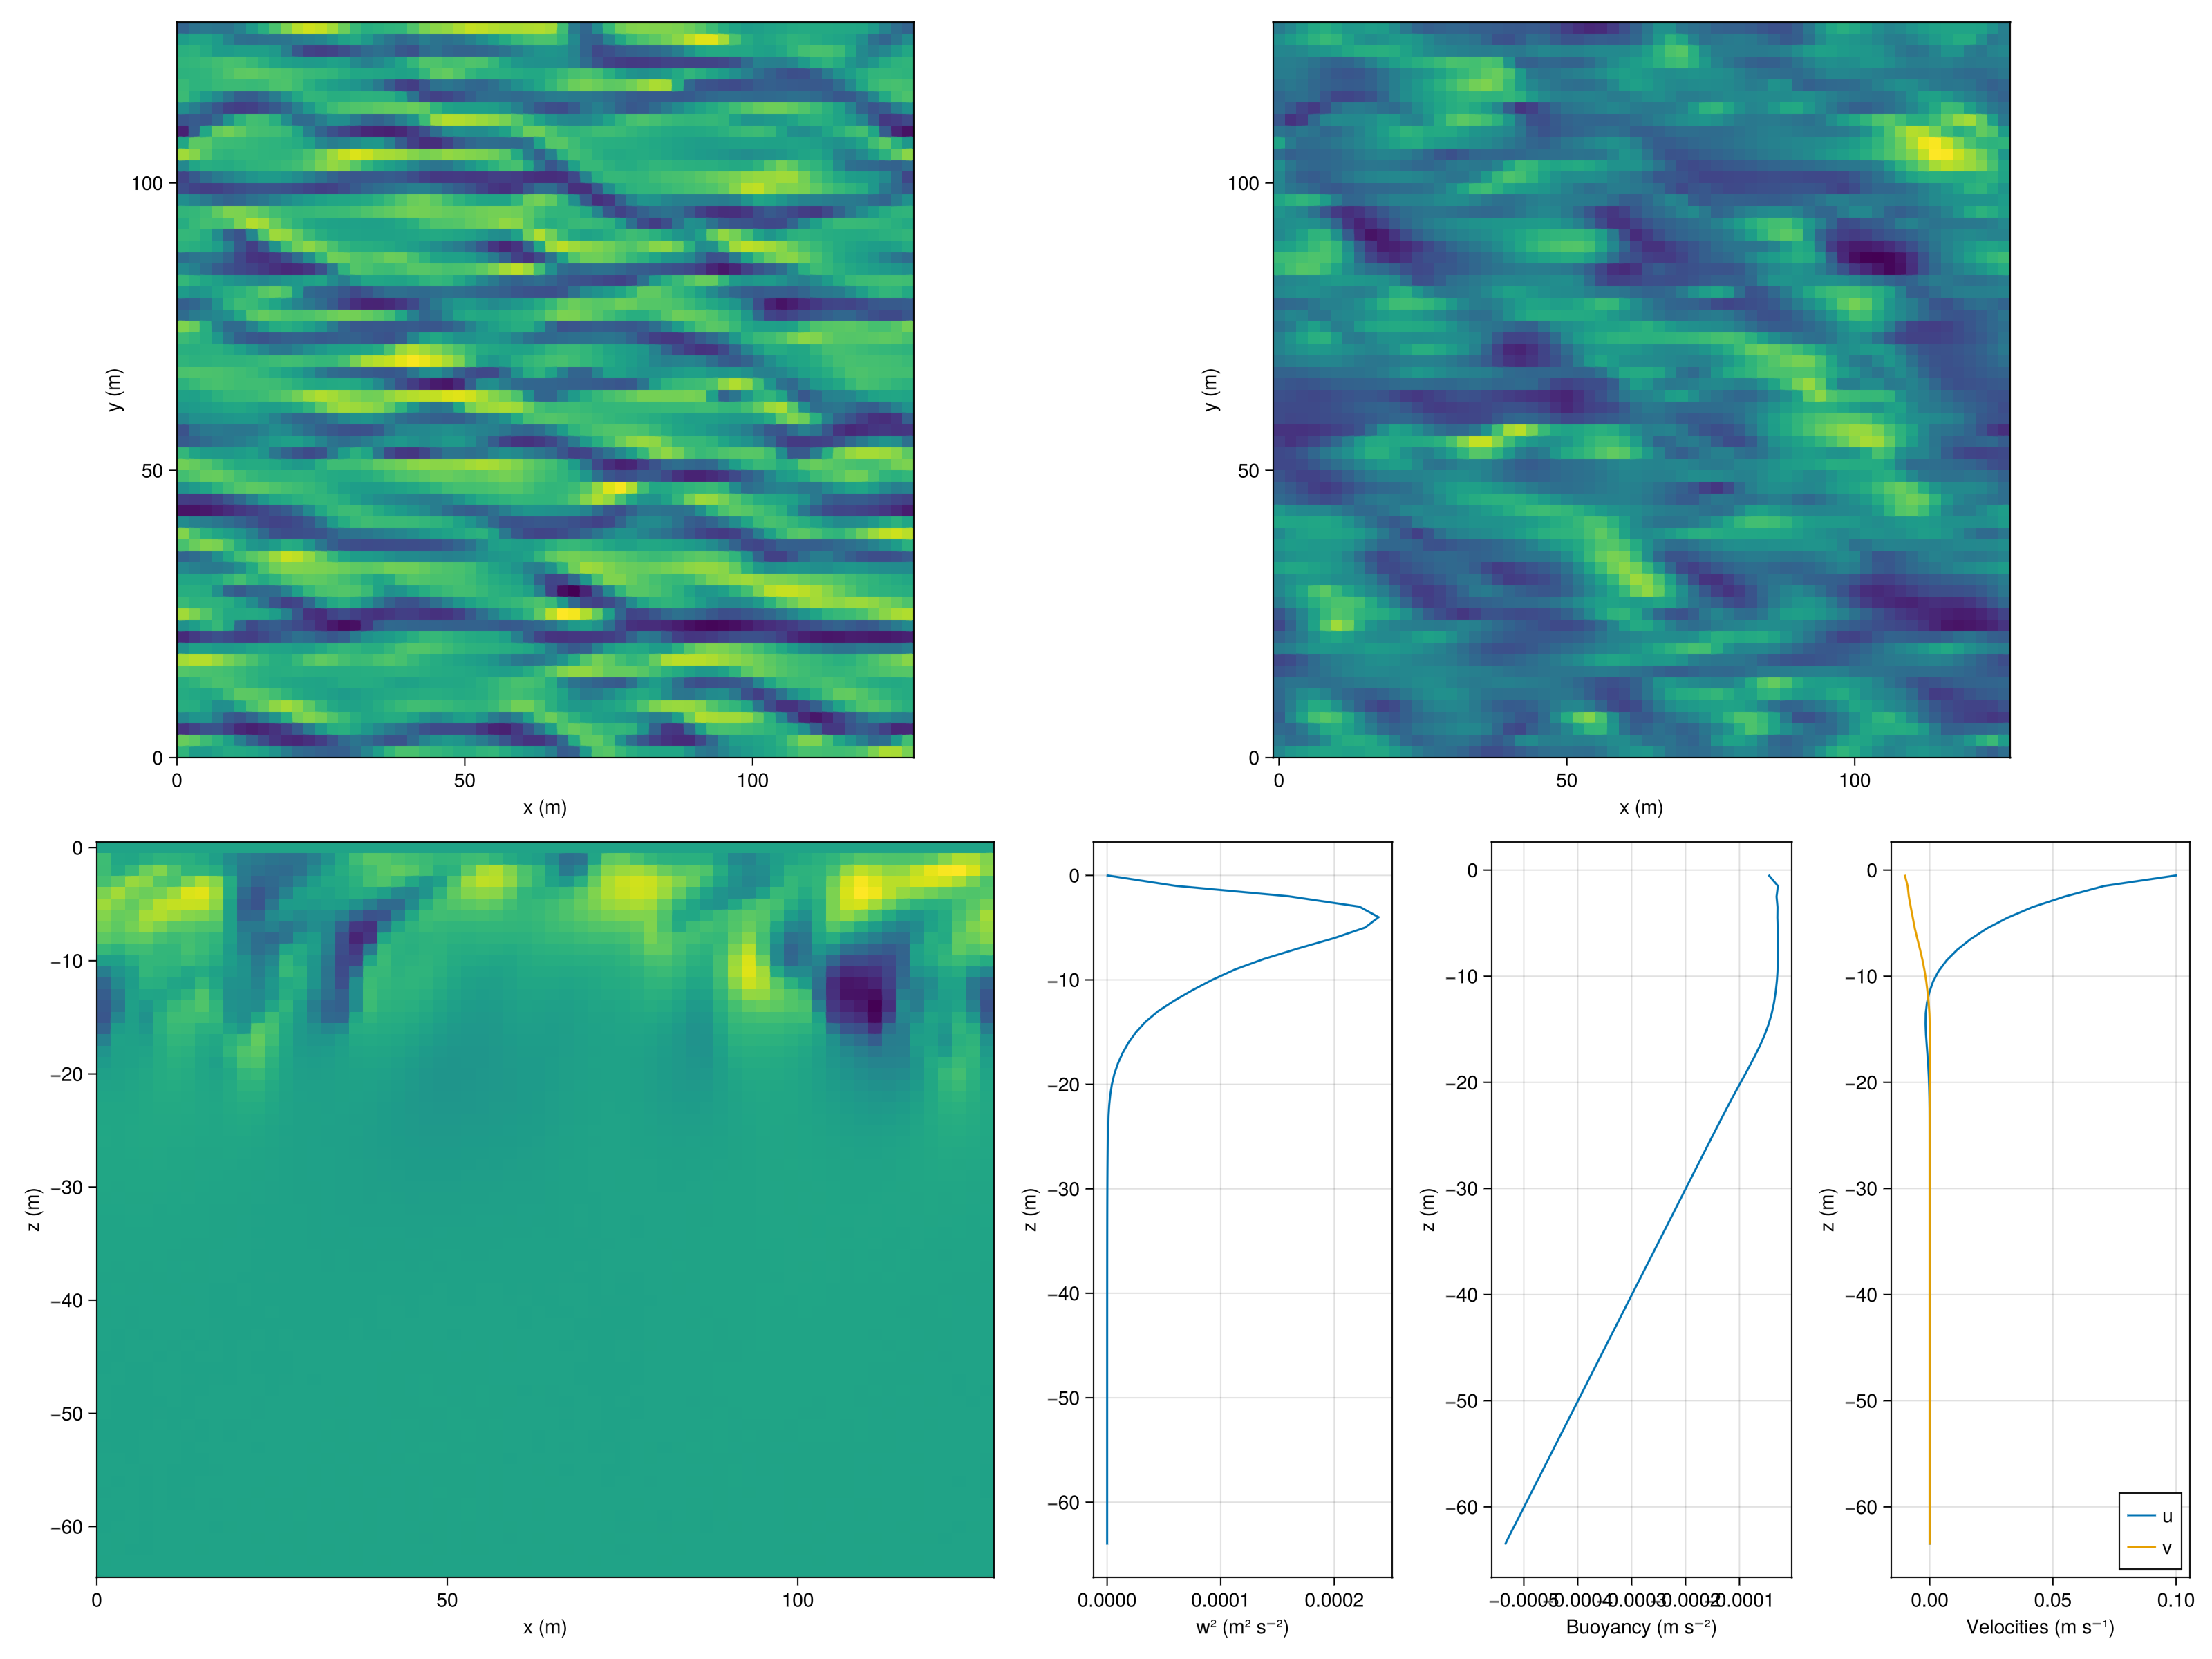

In [24]:
using GLMakie

wt = FieldTimeSeries("langmuir_turbulence_fields.jld2", "w")
ut = FieldTimeSeries("langmuir_turbulence_fields.jld2", "u")

W²t = FieldTimeSeries("langmuir_turbulence_averages.jld2", "w²")
Ut = FieldTimeSeries("langmuir_turbulence_averages.jld2", "u")
Vt = FieldTimeSeries("langmuir_turbulence_averages.jld2", "v")
Bt = FieldTimeSeries("langmuir_turbulence_averages.jld2", "b")

Nt = length(wt)
t = wt.times
xw, yw, zw = nodes(wt)
xb, yb, zb = nodes(Bt)
xu, yu, zu = nodes(ut)

fig = Figure(size=(1600, 1200))

axwxy = Axis(fig[1, 1], aspect=1, xlabel="x (m)", ylabel="y (m)")
axuxy = Axis(fig[1, 2:4], aspect=1, xlabel="x (m)", ylabel="y (m)")

axw  = Axis(fig[2, 1], xlabel="x (m)", ylabel="z (m)")
axw² = Axis(fig[2, 2], xlabel="w² (m² s⁻²)", ylabel="z (m)")
axb  = Axis(fig[2, 3], xlabel="Buoyancy (m s⁻²)", ylabel="z (m)")
axu  = Axis(fig[2, 4], xlabel="Velocities (m s⁻¹)", ylabel="z (m)")

n = Nt
wn = interior(wt[n], :, 1, :)
Un = interior(Ut[n], 1, 1, :)
Vn = interior(Vt[n], 1, 1, :)
W²n = interior(W²t[n], 1, 1, :)
Bn = interior(Bt[n], 1, 1, :)

wxyn = interior(wt[n], :, :, Nz)
uxyn = interior(ut[n], :, :, Nz)

heatmap!(axwxy, xw, yw, wxyn)
heatmap!(axuxy, xu, yu, uxyn)

heatmap!(axw, xw, zw, wn)
lines!(axw², W²n, zw)
lines!(axb, Bn, zb)
lines!(axu, Un, zb, label="u")
lines!(axu, Vn, zb, label="v")
axislegend(axu, position=:rb)

colsize!(fig.layout, 1, Relative(0.5))

fig

In [15]:
Bt

1×1×64×7 FieldTimeSeries{InMemory} located at (⋅, ⋅, Center) of b at langmuir_turbulence_averages.jld2
├── grid: 64×64×64 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 3×3×3 halo
├── indices: (:, :, 1:64)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: langmuir_turbulence_averages.jld2
├── name: b
└── data: 1×1×64×7 OffsetArray(::Array{Float64, 4}, 1:1, 1:1, 1:64, 1:7) with eltype Float64 with indices 1:1×1:1×1:64×1:7
    └── max=9.54964e-5, min=-1.72186e-6, mean=5.49978e-6

In [16]:
Bn

64-element view(::Array{Float64, 4}, 1, 1, :, 7) with eltype Float64:
  4.077599248900972e-7
  4.5340285774054503e-7
  4.851110742025813e-7
  4.965496295020949e-7
  5.007510142313152e-7
  5.027355652899852e-7
  4.969545759152931e-7
  5.012641125161839e-7
  5.028429781949441e-7
  5.009074636460312e-7
  5.022500910955645e-7
  4.930326300247849e-7
  5.018157897716183e-7
  ⋮
  6.80584731391909e-6
  8.081660950651953e-6
  9.573819795085072e-6
  1.1007660887881284e-5
  1.2211234499641187e-5
  1.2895294523696367e-5
  1.3617888248971341e-5
  1.3400228557316823e-5
  1.4370443592122986e-5
  1.2373582938858675e-5
  1.4694840196441733e-5
 -1.7218632577884983e-6